In [1]:

%matplotlib inline
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import FinanceDataReader as fdr
import tensorflow as tf

import matplotlib.pyplot as plt
from pathlib import Path
from shutil import copyfile, move
from mpl_finance import candlestick2_ochl

Using TensorFlow backend.


In [2]:
def ohlc2cs(fname, seq_len, dimension):
    print("Converting olhc to candlestick")
    df = pd.read_csv(fname)
    df.fillna(0)
    df.reset_index(inplace=True)
    print(df["Close"])
    figs = np.zeros((len(df)-1, dimension, dimension, 3))
    labels = []
    
    for i in range(0, len(df)-1):
        c = df.ix[i:i + int(seq_len) - 1, :]
        c_ = df.ix[i:i + int(seq_len), :]
        if len(c) == int(seq_len):
            my_dpi = 96
            fig = plt.figure(figsize=(dimension / my_dpi,
                                      dimension / my_dpi), dpi=my_dpi)
            ax1 = fig.add_subplot(1, 1, 1)
            c=c.loc[:,"Close":"Change"].astype(float)
            candlestick2_ochl(ax1, c['Open'], c['Close'], c['High'],c['Low'], width=1,colorup='#77d879', 
                              colordown='#db3f3f')
            ax1.grid(False)
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.xaxis.set_visible(False)
            ax1.yaxis.set_visible(False)
            ax1.axis('off')
          
        starting = c_["Close"].iloc[-2]
        endvalue = c_["Close"].iloc[-1]
        if endvalue > starting :
            label = 1
        else :
            label = 0
        labels.append(label)

        fig.canvas.draw()
        fig_np = np.array(fig.canvas.renderer._renderer)
        figs[i] = fig_np[:,:,:3]
        plt.close(fig)
    return figs, labels

In [5]:
df = fdr.DataReader("KS11","2009")
y=np.where(df["Change"].shift(-1).dropna()>0,1,0)

df.to_csv('kospi.csv')
inputs = 'kospi.csv'
seq_len = 20
dimension = 48

figures, labels = ohlc2cs(inputs, seq_len, dimension)

figures = figures/255.0

setlen = int(len(df) * 0.7)
X_train,X_test,Y_train,Y_test = figures[:setlen],figures[setlen:],np.array(labels[:setlen]),np.array(labels[setlen:])

Converting olhc to candlestick
0       1157.40
1       1173.57
2       1194.28
3       1228.17
4       1205.70
         ...   
2731    2250.57
2732    2262.64
2733    2239.69
2734    2267.25
2735    2246.13
Name: Close, Length: 2736, dtype: float64


C:\Program Files\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()
C:\Program Files\anaconda3\lib\site-packages\pandas\core\indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
C:\Program Files\anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/inde

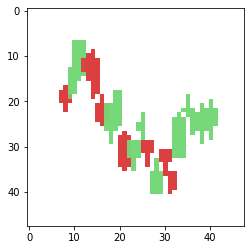

In [6]:
###### 만들어진 차트 이미지 중 하나를 예시로 그려보겠습니다.
import matplotlib as mpl
import matplotlib.pylab as plt
%matplotlib inline
plt.figure()
plt.imshow(figures[1])
plt.show()


In [7]:
### from tensorflow import keras
from tensorflow.keras import layers

# 첫번째 시도할 구조는 논문에서 제시한 CNN 구조
# CNN의 filter size, dropout rate, padding 등은 언급이 안되어 있어서 임의로 넣음

from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
model = Sequential()
model.add(Conv2D(256,3,activation='relu',padding="same"))
model.add(MaxPooling2D(2))
model.add(Conv2D(96,3,activation='relu',padding="same"))
model.add(MaxPooling2D(2))
model.add(Dropout(0.5))
model.add(Conv2D(64,3,activation='relu',padding="same"))
model.add(MaxPooling2D(2))
model.add(Conv2D(48,3,activation='relu',padding="same"))
model.add(MaxPooling2D(2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(24,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.fit(X_train,Y_train, epochs=10,batch_size=16,validation_split=0.3)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1340 samples, validate on 575 samples
Epoch 1/10
1340/1340 [==============================] - 20s 15ms/step - loss: 0.7033 - accuracy: 0.5037 - val_loss: 0.6930 - val_accuracy: 0.5096
Epoch 2/10
1340/1340 [==============================] - 21s 15ms/step - loss: 0.6939 - accuracy: 0.5037 - val_loss: 0.6930 - val_accuracy: 0.5096
Epoch 3/10
1340/1340 [==============================] - 20s 15ms/step - loss: 0.6931 - accuracy: 0.5231 - val_loss: 0.6930 - val_accuracy: 0.5096
Epoch 4/10
1340/1340 [==============================] - 20s 15ms/step - loss: 0.6929 - accuracy: 0.5224 - val_loss: 0.6930 - val_accuracy: 0.5096
Epoch 5/10
1340/1340 [==============================] - 20s 15ms/step - loss: 0.6926 - accuracy: 0.5246 - val_loss: 0.6930 - val_accuracy: 0.5096
Epoch 6/10
1340/1340 [==============================] - 21s 15ms/step - loss: 0.6923 - accuracy: 0.5254 - val_loss: 0.6931 - va

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,np.where(model.predict(X_test)>0.5,1,0))

0.5280487804878049